In [476]:
import pandas_datareader.data as web
import datetime
import pandas as pd
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

portfolio = pd.read_csv("stockData.csv")
asset_list = portfolio.columns[1:]
num_assets = len(asset_list)
train_start = 420
# print the date of the start of the training data
print(portfolio.iloc[train_start, 0])
train_end = 500+train_start
portfolio = portfolio.iloc[train_start:train_end]
num_days = train_end - train_start + 1
# drop first column
portfolio = portfolio.drop(portfolio.columns[0], axis=1)

print(portfolio)

2014-12-11
     ADANIPORTS  ASIANPAINT  AXISBANK     HDFC     ITC      TCS  HINDUNILVR  \
420      278.45      774.92    487.46  1100.24  394.72  2505.66      797.05   
421      282.14      776.39    487.19  1080.58  396.82  2459.33      800.66   
422      285.06      769.04    481.03  1111.26  393.71  2370.64      792.90   
423      279.11      758.95    471.12  1094.69  382.18  2426.81      775.38   
424      273.67      737.23    474.27  1095.49  373.71  2445.41      766.58   
425      286.07      743.75    484.65  1091.40  373.56  2453.57      765.35   
426      290.02      746.09    491.91  1114.25  371.39  2503.39      760.11   
427      290.11      743.33    492.51  1132.52  374.06  2495.66      765.54   
428      291.69      740.42    500.19  1141.58  374.80  2514.24      766.06   
429      283.98      730.27    493.94  1104.46  372.77  2485.30      757.79   
430      287.20      727.45    494.99  1108.33  368.38  2488.46      749.46   
431      292.03      747.10    494.55  11

In [477]:
returns = portfolio.pct_change().dropna()
print(returns)

# calculate the expected returns
expected_returns = returns.mean()
print(expected_returns)

# calculate the covariance matrix
cov_matrix = returns.cov()
print(cov_matrix)

     ADANIPORTS  ASIANPAINT  AXISBANK      HDFC       ITC       TCS  \
421    0.013252    0.001897 -0.000554 -0.017869  0.005320 -0.018490   
422    0.010349   -0.009467 -0.012644  0.028392 -0.007837 -0.036063   
423   -0.020873   -0.013120 -0.020602 -0.014911 -0.029286  0.023694   
424   -0.019491   -0.028618  0.006686  0.000731 -0.022162  0.007664   
425    0.045310    0.008844  0.021886 -0.003733 -0.000401  0.003337   
426    0.013808    0.003146  0.014980  0.020936 -0.005809  0.020305   
427    0.000310   -0.003699  0.001220  0.016397  0.007189 -0.003088   
428    0.005446   -0.003915  0.015594  0.008000  0.001978  0.007445   
429   -0.026432   -0.013708 -0.012495 -0.032516 -0.005416 -0.011510   
430    0.011339   -0.003862  0.002126  0.003504 -0.011777  0.001271   
431    0.016818    0.027012 -0.000889  0.013687  0.003583  0.013663   
432    0.064069    0.008767  0.002426  0.001745 -0.001163  0.003057   
433    0.018215   -0.000809  0.014745  0.006371 -0.001164  0.005873   
434   

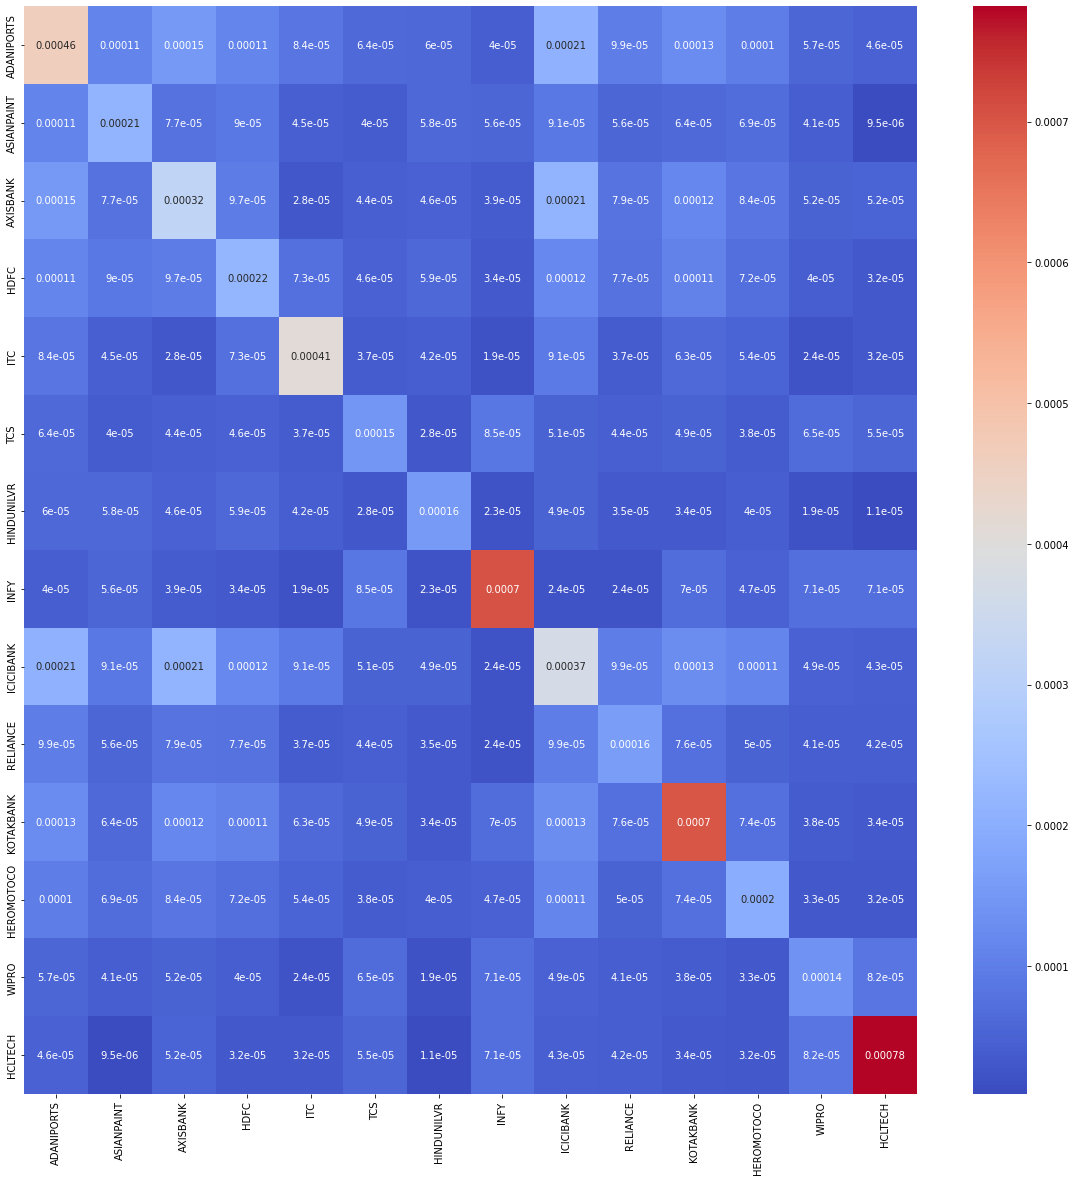

In [478]:
# plot this covariance matrix into a heatmap
import seaborn as sb
plt.figure(figsize=(20, 20))
sb.heatmap(cov_matrix, annot=True, cmap='coolwarm')
plt.show()


In [479]:
def portfolio_return(weights, returns):
    return weights.T.dot(returns)

def portfolio_variance(weights, cov_matrix):
    return weights.T.dot(cov_matrix).dot(weights)


In [480]:
def objective_function(weights, cov_matrix, expected_returns, risk_aversion):
    portfolio_ret = portfolio_return(weights, expected_returns)
    portfolio_var = portfolio_variance(weights, cov_matrix)
    objective = portfolio_ret - risk_aversion * portfolio_var
    return objective

def gradient(mu, cov_matrix, alpha, weights):
    portfolio_var = portfolio_variance(weights, cov_matrix)
    risk_gradient = alpha * cov_matrix.dot(weights)/portfolio_var
    return mu + 4*risk_gradient

def gradient_descent(mu, cov_matrix, alpha, learning_rate, num_iterations, threshold,random_weights, weights_value=[], objective_value=[], gradient_value=[]):
    weights = random_weights
    for i in range(num_iterations):
        gradient_val = gradient(mu, cov_matrix, alpha, weights)
        gradient_value.append(gradient_val)
        weights = weights + learning_rate * gradient_val
        weights = weights / np.sum(weights)
        weights_value.append(weights)
        objective_value.append(objective_function(weights, cov_matrix, expected_returns, alpha))
        if np.linalg.norm(gradient(mu, cov_matrix, alpha, weights)) < threshold:
            break
    return weights, objective_value, weights_value, gradient_value

In [481]:
alpha = 0.0001
learning_rate = 1
num_iterations = 5000
threshold = 1e-8
weights_value = []
objective_value = []
gradient_value = []
weights = np.random.rand(num_assets)
weights = weights / np.sum(weights)
print(weights)
weights, objective_value, weights_value, gradient_value = gradient_descent(expected_returns, cov_matrix, alpha, learning_rate, num_iterations, threshold, weights)
print(weights)


[0.11121168 0.02935372 0.11235103 0.06232602 0.05743956 0.08733176
 0.11055799 0.05999191 0.08889002 0.10866967 0.05052492 0.08823329
 0.030262   0.00285645]
ADANIPORTS    12353.255495
ASIANPAINT    11634.552236
AXISBANK       7982.605333
HDFC          12582.934907
ITC          -17363.250436
TCS             213.018743
HINDUNILVR     6432.554518
INFY         -17743.163248
ICICIBANK     -2960.650258
RELIANCE      13112.290971
KOTAKBANK     -9759.414285
HEROMOTOCO     6062.197658
WIPRO         -4375.660313
HCLTECH      -18170.271324
dtype: float64


In [482]:
weights = np.maximum(weights, 0)
weights = weights / np.sum(weights)
print(weights)

ADANIPORTS    0.175539
ASIANPAINT    0.165326
AXISBANK      0.113432
HDFC          0.178802
ITC           0.000000
TCS           0.003027
HINDUNILVR    0.091406
INFY          0.000000
ICICIBANK     0.000000
RELIANCE      0.186325
KOTAKBANK     0.000000
HEROMOTOCO    0.086143
WIPRO         0.000000
HCLTECH       0.000000
dtype: float64


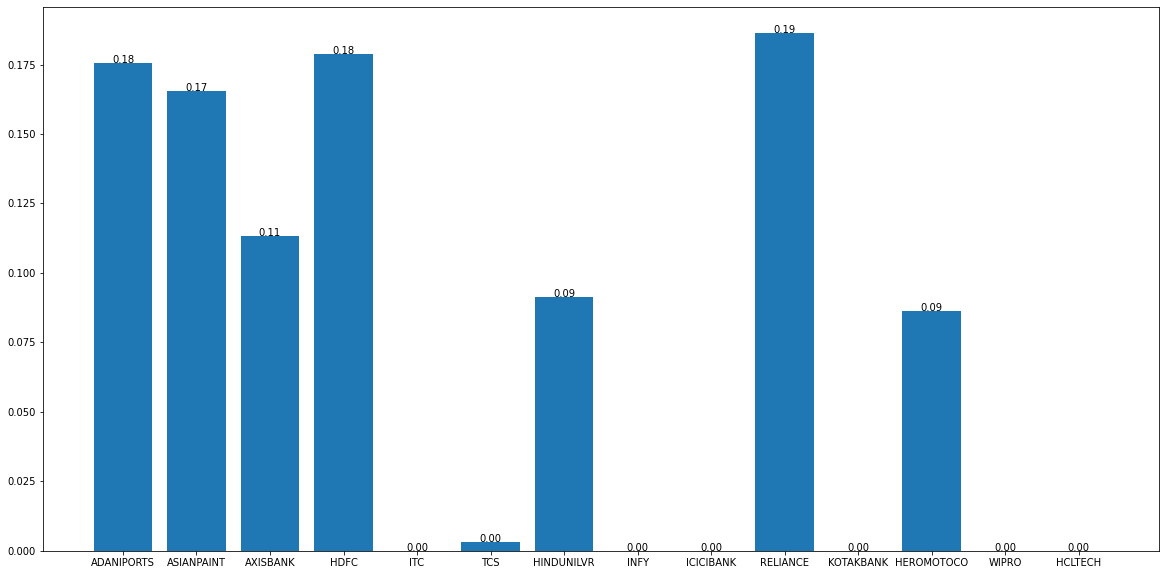

In [483]:
import matplotlib.pyplot as plt
# show the percentage of the portfolio on top of the bars
plt.figure(figsize=(20, 10))
plt.bar(asset_list, weights)
for i in range(len(weights)):
    plt.text(i, weights[i], "{:.2f}".format(weights[i]), ha='center')
plt.show()

In [484]:
stockData = pd.read_csv("stockData.csv")

testDays = [250, 500]
testStart = train_end + 1
risk_free_rate = 0.075

for i in range(len(testDays)):
    # print("Test Days: ", testDays[i])
    testEnd = testStart + testDays[i]
    portfolio_test = stockData.iloc[testStart:testEnd, :]
    portfolio_test = portfolio_test.drop(portfolio_test.columns[0], axis=1)
    returns = portfolio_test.pct_change().dropna()
    cov_matrix = returns.cov()
    portfolio_return = np.sum(returns.mean() * weights) * testDays[i]
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(testDays[i])
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std_dev
    # print the expected return, volatility and sharpe ratio and test period in a table
    # print("Test Period: ", testStart, " to ", testEnd)
    print(f'({portfolio_return:.2f}, {portfolio_std_dev:.2f}, {sharpe_ratio:.2f})')

(0.29, 0.14, 1.47)
(0.42, 0.20, 1.66)
